In [ ]:
import warnings
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from mpvn.data.grad.lit_data_module import LightningGradDataModule
from mpvn.metric import WordErrorRate, CharacterErrorRate
from mpvn.model.model import *

from mpvn.configs import DictConfig

: 

In [2]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="valid_loss",
    mode="min",
    dirpath="checkpoint",
    filename="mpvn-{epoch:02d}-{valid_loss:.2f}-{valid_per:.2f}-{valid_acc}",
)
early_stop_callback = EarlyStopping(
    monitor="valid_loss", 
    min_delta=0.00, 
    patience=5, 
    verbose=False, 
    mode="min"
)
logger = TensorBoardLogger("tensorboard", name="Pronunciation for Vietnamese")

In [3]:
configs = DictConfig()

# pl.seed_everything(configs.seed)
warnings.filterwarnings('ignore')

data_module = LightningGradDataModule(configs)
vocab = data_module.get_vocab() 

trainer = pl.Trainer(accelerator='cpu',
                      gpus=0,
                      logger=logger,
                      max_epochs=configs.max_epochs,
                      callbacks=[checkpoint_callback, early_stop_callback])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
model = ConformerRNNModel.load_from_checkpoint(
    'Checkpoint/finetuned-epoch=24-valid_loss=0.14-valid_per=0.47-valid_acc=0.93-valid_f1=0.68.ckpt',
    configs=configs,
    num_classes=len(vocab),
    vocab=vocab,
    per_metric=WordErrorRate(vocab)
)

Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
Result of vivosdev12_213
EP: torch.Size([70]) ________________baː2w-mej-haːjj---b_aː--myəj-baː______________<e><e><e><e><e><e><e><e><e>
PR: torch.Size([21]) baː2wmej-haːj-baː-myəj-baː<e>
Ro: torch.Size([21]) baː-myəj-haːj-baː-myəj-baː<e>
Rc: torch.Size([21]) baː-myəj-hu4j-bəɪ6-tʃyəp-baː<e>
Per: 0.1875
MED output   : tensor([1, 1, 0, 0, 0, 1])
Score        : tensor([1, 1, 0, 0, 0, 1])
Accuracy: 1.0
Decoder-Encoder Attention: torch.Size([21, 70])


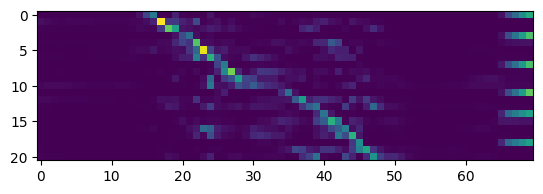

Validation DataLoader 0: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]

2023-02-28 23:03:11.464184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 23:03:12.857385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 23:03:12.857442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-28 23:03:13.052241: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-28 23:03:16.118463: W tensorflow/stream_executor/platform/de

Validation DataLoader 0: 100%|██████████| 50/50 [00:15<00:00,  3.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        valid_acc           0.8117131757131755
        valid_f1            0.8256608767087295
       valid_loss           0.5651592016220093
        valid_per           0.16256242990493774
     valid_precision        0.7599438894438896
      valid_recall           0.939420634920635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid_loss': 0.5651592016220093,
  'valid_per': 0.16256242990493774,
  'valid_acc': 0.8117131757131755,
  'valid_f1': 0.8256608767087295,
  'valid_precision': 0.7599438894438896,
  'valid_recall': 0.939420634920635}]

In [5]:
trainer.validate(model, data_module)

In [6]:
# model.df

In [7]:
trainer.test(model, data_module)

Testing DataLoader 0: 100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


[{}]

In [8]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, auc
score = ' '.join(list(model.df.score))
predict = ' '.join(list(model.df.score_predict))
score = [int(i) for i in score.split()]
predict = [int(i) for i in predict.split()]
accuracy_score(score, predict), f1_score(score, predict, pos_label=0), recall_score(score, predict, pos_label=0), precision_score(score, predict, pos_label=0)

(0.723823975720789, 0.5539215686274509, 0.5707070707070707, 0.5380952380952381)


  | Name         | Type             | Params
--------------------------------------------------
0 | criterion    | JointLoss        | 0     
1 | encoder      | ConformerEncoder | 2.6 M 
2 | decoder      | RNNDecoder       | 267 K 
3 | word_decoder | WordDecoder      | 282 K 
--------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.710    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]
Result of vivosdev04_r162
EP: torch.Size([66]) _____k_u_--tʃ_i2-məːɜjj-v_aː2w-lyəɜ--ɲɲ_ə6t̪-bɔɜŋ-h_aːj_lɔ2m_____<e><e><e><e><e><e><e>
PR: torch.Size([34]) ku-tʃi2-məːɜj-vaː2w-lyəɜj-ɲə6t̪-bɔɜŋ-haːj-lɔ2m<e>
Ro: torch.Size([34]) ko-tʃi4-məːɜj-vaː2w-lyəɜj-ɲa6t̪-bɔɜŋ-haːj-lə2n<e>
Rc: torch.Size([34]) ko-tʃi4-bɛ4j-ɗaː2m-lyəɜj-puəɜt̪-ŋɔɜm-haːj-lyə6ŋ<e>
Per: 0.19230769230769232
MED output   : tensor([0, 0, 0, 0, 0, 0, 0, 1, 0])
Score        : tensor([1, 1, 0, 0, 1, 0, 0, 1, 0])
Accuracy: 0.6666666666666666
Decoder-Encoder Attention: torch.Size([34, 66])


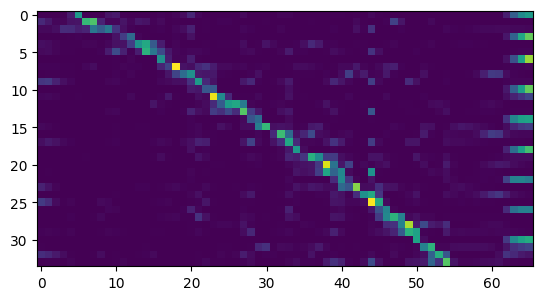

Epoch 0:   0%|          | 0/12199 [00:00<?, ?it/s]                         

FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/librosa/core/audio.py", line 164, in load
    y, sr_native = __soundfile_load(path, offset, duration, dtype)
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/librosa/core/audio.py", line 195, in __soundfile_load
    context = sf.SoundFile(path)
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/soundfile.py", line 655, in __init__
    self._file = self._open(file, mode_int, closefd)
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/soundfile.py", line 1213, in _open
    raise LibsndfileError(err, prefix="Error opening {0!r}: ".format(self.name))
soundfile.LibsndfileError: Error opening 'Data/inforeTTS/wavs/0/8/08749.wav': System error.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/media/wicii/DDH/class/graduation_project/mpvn/mpvn/data/dataset.py", line 243, in __getitem__
    audio_feature = self._parse_audio(audio_path, self.spec_augment_flags[idx])
  File "/media/wicii/DDH/class/graduation_project/mpvn/mpvn/data/dataset.py", line 174, in _parse_audio
    signal, sr = librosa.load(audio_path, sr=self.sample_rate)
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/librosa/util/decorators.py", line 88, in inner_f
    return f(*args, **kwargs)
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/librosa/core/audio.py", line 170, in load
    y, sr_native = __audioread_load(path, offset, duration, dtype)
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/librosa/core/audio.py", line 226, in __audioread_load
    reader = audioread.audio_open(path)
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/audioread/__init__.py", line 127, in audio_open
    return BackendClass(path)
  File "/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/audioread/rawread.py", line 59, in __init__
    self._fh = open(filename, 'rb')
FileNotFoundError: [Errno 2] No such file or directory: 'Data/inforeTTS/wavs/0/8/08749.wav'


In [5]:
trainer.fit(model, data_module)